In [1]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [2]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)

In [3]:
# dictionary to save the results
results={}

## Constants

In [4]:
SIZE_RESERVOIR = 100
LAMBDA_REG = 0.7
MAX_ITER = 60000
PRECISION = 1e-3

## fix the resevoir

In [5]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))
H = sigmoid(resevoir @ tr_x)
E = H @ H.T + np.power(LAMBDA_REG, 2) * np.eye(H.shape[0])

In [6]:
condition_number = np.linalg.cond(E)
print(f"Condition number of E: {condition_number}")

Condition number of E: 72852.03483013499


# OPTIMAL SOLUTION

In [7]:
# Calculate the optimal solution
start_optimal = datetime.datetime.now()
w_star, _, _, _ = np.linalg.lstsq(E, H @ tr_y.T, rcond=-1)
end_optimal = (datetime.datetime.now() - start_optimal).microseconds

In [8]:
results["Optimal"] = mse(w_star.T@H, tr_y), "-", "-", end_optimal

In [9]:
print("Mean square error: ", results["Optimal"][0])
print("Time: ", results["Optimal"][3])

Mean square error:  1.710917591093173
Time:  3329


## Cholesky solution

In [10]:
output = fit_cholesky(tr_x, tr_y, lambda_=LAMBDA_REG, resevoir=resevoir,w_star=w_star.T, mode="verbose")
f_star = output["model"](tr_x)

In [11]:
results["Cholesky"] = get_results(output["model"], tr_x, tr_y), output["gap_sol"], "-", output["elapsed_time"]

In [12]:
print("Cholesky Mean square error: ", results["Cholesky"][0])
print("Cholesky Relative Gap Sol: ", results["Cholesky"][1])
print("Cholesky Time elapsed: ", results["Cholesky"][3])

Cholesky Mean square error:  1.710917591093677
Cholesky Relative Gap Sol:  1.6583932490534308e-11
Cholesky Time elapsed:  39110


## Iterative methods

In [13]:
output_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                        eps=PRECISION, resevoir=resevoir, w_star=w_star.T, f_star=f_star, mode="verbose")
classical_sgd, time = output_sgd["model"], output_sgd["elapsed_time"]

In [14]:
sgd_gap_sol = output_sgd["metrics"]["Gap_Sol"].tail(1).values[0]
sgd_gap_pred = output_sgd["metrics"]["Gap_Pred"].tail(1).values[0]
results["classical-SGD"] = get_results(classical_sgd, tr_x, tr_y), sgd_gap_sol, sgd_gap_pred, time

In [15]:
print("SGD Mean square error: ", results["classical-SGD"][0])
print("SGD Relative Gap Sol: ", results["classical-SGD"][1])
print("SGD Relative Gap Pred: ", results["classical-SGD"][2])
print("SGD Time elapsed: ", results["classical-SGD"][3])
print("SGD Norm-Grad: ", output_sgd["norm_grad"])


SGD Mean square error:  1.749538953887621
SGD Relative Gap Sol:  0.21728374502018338
SGD Relative Gap Pred:  0.0037476291458688627
SGD Time elapsed:  232724
SGD Norm-Grad:  9.278159620219714


In [16]:
output_fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                  eps=PRECISION, resevoir=resevoir, w_star=w_star.T, f_star=f_star, mode="verbose")
fista, time = output_fista["model"], output_fista["elapsed_time"]

In [17]:
fista_gap_sol = output_fista["metrics"]["Gap_Sol"].tail(1).values[0]
fista_gap_pred = output_fista["metrics"]["Gap_Pred"].tail(1).values[0]
results["FISTA"] = get_results(fista, tr_x, tr_y), fista_gap_sol, fista_gap_pred, time

In [18]:
print("FISTA Mean square error: ", results["FISTA"][0])
print("FISTA Relative Gap Sol: ", results["FISTA"][1])
print("FISTA Relative Gap Pred: ", results["FISTA"][2])
print("FISTA Time elapsed: ", results["FISTA"][3])
print("FISTA Norm-Grad: ", output_fista["norm_grad"])


FISTA Mean square error:  1.7109176236043333
FISTA Relative Gap Sol:  9.665182460527929e-05
FISTA Relative Gap Pred:  1.622398981818351e-06
FISTA Time elapsed:  907483
FISTA Norm-Grad:  0.004048874829839959


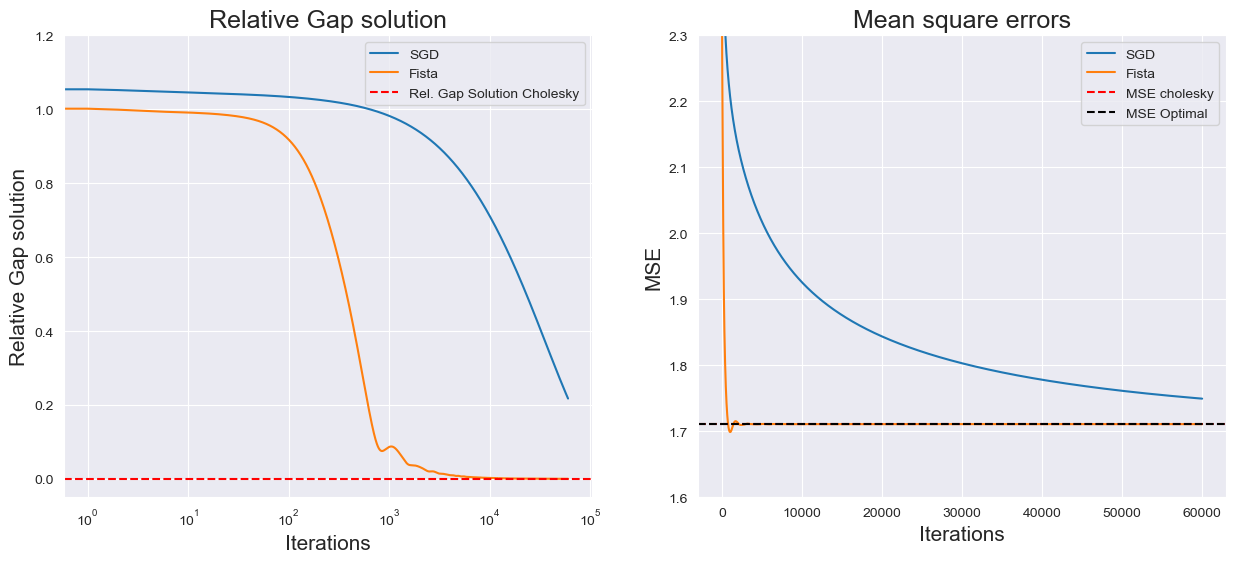

In [19]:
_, axs = plt.subplots(ncols=2,figsize=(15,6))

sns.lineplot(data=output_sgd["metrics"], x=output_sgd["metrics"].index, y="Gap_Sol", ax=axs[0], label="SGD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="Gap_Sol", ax=axs[0], label="Fista")
axs[0].axhline(y=output["gap_sol"], label="Rel. Gap Solution Cholesky", color="red", linestyle="--")
axs[0].set_title("Relative Gap solution",fontsize=18)
axs[0].set_ylabel("Relative Gap solution",fontsize=15)
axs[0].set_xlabel("Iterations",fontsize=15)
axs[0].set_ylim([-0.05,1.2])
axs[0].set_xscale("log")
axs[0].legend()


sns.lineplot(data=output_sgd["metrics"], x=output_sgd["metrics"].index, y="MSE", ax=axs[1], label="SGD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="MSE", ax=axs[1], label="Fista")
axs[1].axhline(y=results["Cholesky"][0], label="MSE cholesky", color="red", linestyle="--")
axs[1].axhline(y=results["Optimal"][0], label="MSE Optimal", color="black", linestyle="--")
axs[1].set_title("Mean square errors",fontsize=18)
axs[1].set_ylabel("MSE",fontsize=15)
axs[1].set_xlabel("Iterations",fontsize=15)
axs[1].set_ylim([1.6, 2.3])
axs[1].legend()

plt.show()


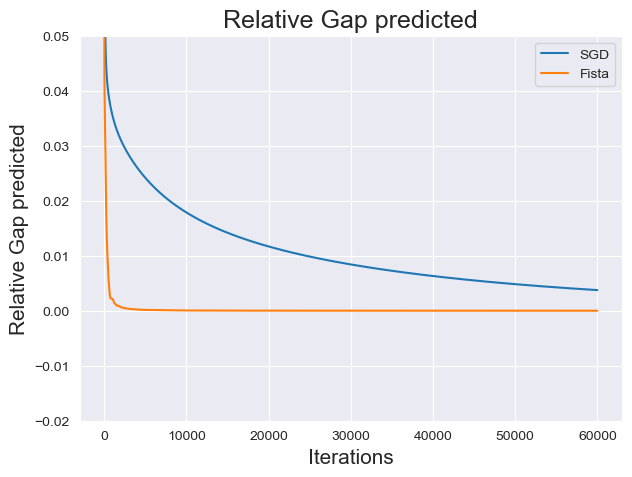

In [26]:
_, axs = plt.subplots(figsize=(7, 5))

sns.lineplot(data=output_sgd["metrics"], x=output_sgd["metrics"].index, y="Gap_Pred", ax=axs, label="SGD")
sns.lineplot(data=output_fista["metrics"], x=output_fista["metrics"].index, y="Gap_Pred", ax=axs, label="Fista")
axs.set_title("Relative Gap predicted",fontsize=18)
axs.set_ylabel("Relative Gap predicted",fontsize=15)
axs.set_xlabel("Iterations",fontsize=15)
axs.set_ylim([-0.02,0.05])
# axs.set_xscale("log")
axs.legend()

plt.show()

In [21]:
print(f"{'Method' : ^20}{'MSE' : ^25}{'Rel. gap sol' : ^25}{'Rel. gap pred' : ^25}{'Time(microseconds)' : ^20}")

for k,v in results.items():
    print(f"{k : ^20}{v[0]:^25}{v[1] : ^25}{v[2] : ^25}{v[3] : ^20}")

       Method                  MSE                 Rel. gap sol             Rel. gap pred       Time(microseconds) 
      Optimal           1.710917591093173                -                        -                    3329        
      Cholesky          1.710917591093677     1.6583932490534308e-11              -                   39110        
   classical-SGD        1.749538953887621       0.21728374502018338     0.0037476291458688627         232724       
       FISTA           1.7109176236043333      9.665182460527929e-05    1.622398981818351e-06         907483       


In [22]:
#  Method                  MSE                 Rel. gap sol             Rel. gap pred       Time(microseconds)
# Optimal          1.6388197559488462                -                        -                    2330
# Cholesky         1.6388197559489057      8.207429492695296e-12              -                   49303
# classical-SGD        1.768291990981327       0.5358654667701107      0.013627144849373487          515549
# FISTA            1.638799836701456      0.0006065865055070653   1.4207854186904863e-05         757722

In [23]:
# output_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=0.5, max_inters=1000000,
#                      eps=1e-3, hidden=100, w_star=w_star.T, f_star=f_star, mode="testing")